# Geometric Multigrid
Nicholas Moore

## Introduction
We follow the analysis from "A Multigrid Tutorial" by William Briggs.  This presentation will focus on the use of the Multigrid Method as a solver for the 1D Poisson problem, though the concepts and ideas can be applied to problems of higher dimension, or as a preconditioner instead of a solver.

In [1]:
from prettytable import PrettyTable
from IPython.display import HTML
import time
import numpy as np
from numpy.linalg import norm, solve
import scipy.sparse as sp
import scipy.sparse.linalg as splu
import matplotlib.pyplot as plt
from numpy.random import MT19937, RandomState, SeedSequence
rs = RandomState(MT19937(SeedSequence(123456789)))

# We will be profiling code later, this extension allows line-by-line profiling
%load_ext line_profiler


# Unified mvmult user interface for both scipy.sparse and numpy matrices.
# In scipy.sparse, mvmult is done using the overloaded * operator, e.g., A*x.
# In numpy, mvmult is done using the dot() function, e.g., dot(A,x).
# This function chooses which to use based on whether A is stored as
# a sparse matrix.
def mvmult(A, x):
    if sp.issparse(A):
        return A*x
    else:
        return np.dot(A,x)

## Analyzing the Jacobi Method

### Problem Set Up
First, we create the A matrix.  For simplicity and easy of understanding, we will choose the 1D poisson problem with Dirichlet Bondary Conditions.

The matrix for this problem is given by
$$
A = \frac{1}{h^2}
\begin{bmatrix}
2  & -1 &        &        &        &   \\
-1 &  2 & -1     &        &        &   \\
   & -1 &  2     &     -1 &        &   \\
   &    & \ddots & \ddots & \ddots &   \\
   &    &        &     -1 &      2 & -1 \\
   &    &        &        &     -1 &  2
\end{bmatrix}
$$
so the problem can be written as $Ax = b$.  If $N$ is the number of subintervals we divide the domain into, then this matrix is $N-1 \times N-1$.

For the sake of demonstration, we let the right-hand side vector $b$ correspond to the case of Dirichlet boundary conditions where both ends are held at $0$.  We choose this because the true solution is therefore the zero vector so the error corresponds exactly with the current iterate.

In [21]:
def GeneratePoisson(N):
    # Generate A matrix for poisson problem with N subintervals (N-1 unknowns)
    # Result will be a N-1 x N-1 matrix
    row = N*N*np.array([-1, 2, -1], dtype=np.double)
    A = sp.diags(row, [-1, 0, 1], shape=(N-1, N-1), dtype=np.double, format="csr")
    return A

N = 512
A = GeneratePoisson(N)
b = np.zeros((N-1,1), dtype=np.double)

We also generate some initial guesses (which are also initial errors) which are sine waves with varying frequencies.

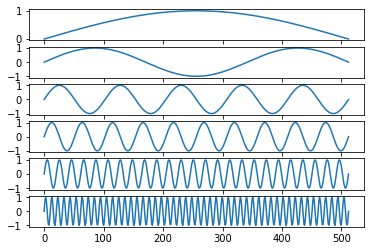

In [22]:
x = np.linspace(0,1,N+1)
waveNumbers = [1, 3, 10, 20, 50, 100]
#waveNumbers = [1, 10, 50, 100]
xinitial = [np.sin(w*np.pi*x) for w in waveNumbers]
fig, axs = plt.subplots(len(waveNumbers),1)
for (i,p) in enumerate(xinitial):
    axs[i].plot(p)

### Create a Jacobi Function

In [23]:
def Jacobi(x, A, b, numiters=1):
    for i in range(numiters):
        # Need a copy of x since we'll be updating x in place
        xold = x.copy()
        
        # Loop through the rows
        for i in range(len(xold)):
            # Calculate the indices of the CSR data array that hold the row
            rowindices = range(A.indptr[i],A.indptr[i+1])
            
            r = 0.
            for j in rowindices:
                col = A.indices[j]
                if col != i:
                    r += A.data[j]*xold[col]
                else:
                    d = A.data[j]
            
            # Update x
            x[i] = (b[i] - r)/d
    return x

### Running Jacobi
Now let's run 100 Jacobi iterations on each of the initial conditions, tracking the error at each iteration.

In [24]:
numJacobiIters = 100

errors = [np.zeros((numJacobiIters+1,1), dtype=np.double) for i in range(len(waveNumbers))]
initialErrorNorms = [np.linalg.norm(w) for w in xinitial]
x_working = xinitial.copy()
for j in range(numJacobiIters+1):
    for (i, w) in enumerate(x_working):
        if j == 0:
            errors[i][j] = np.linalg.norm(w[1:-1])/initialErrorNorms[i]
        else:
            errors[i][j] = np.linalg.norm(Jacobi(w[1:-1], A, b, 1))/initialErrorNorms[i]

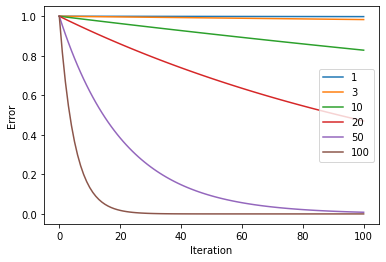

In [25]:
for (i,w) in enumerate(errors):
    plt.plot(w, label = waveNumbers[i])
plt.legend(loc="right")
plt.xlabel("Iteration")
plt.ylabel("Error")
plt.show()

We can also look at our iterates now:

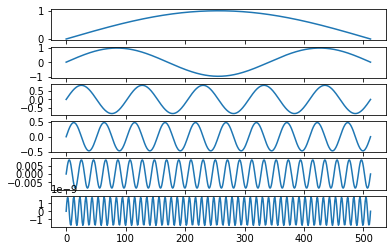

In [26]:
fig, axs = plt.subplots(len(waveNumbers),1)
for (i,p) in enumerate(x_working):
    axs[i].plot(p)

### Why Multigrid Works

Here we see the key to understanding the effectiveness of multigrid: The Jacobi iteration scheme is much better at eliminating high frequency error than low frequency error.

### Other Iteration Methods

While the preceeding discussion uses Jacobi iteration, all relaxation-type iterations methods like Gauss-Seidel and variations of Jacobi and Gauss-Seidel also present this property. In multigrid terminology, these are all generally referred to as relaxations.

### How Do We Use This?

The matrix system does not have any explicit information about the phyiscal structure of the problem.  Hence, if we take a longer vector with low frequency error, and remove half of the points:

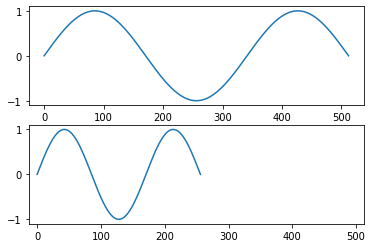

In [27]:
y_fine = np.sin(3*np.pi*x)
x_coarse = np.array([x[i] for i in range(len(x)) if i % 2 == 0])
y_coarse = np.sin(3*np.pi*x_coarse)
fig, axs = plt.subplots(2, 1)
axs[0].plot(y_fine)
axs[1].plot(y_coarse)
plt.xlim(right=N)
plt.show()

we can see that we have the same number of oscillations, but in half the number of nodes. For Jacobi, which has no information about the entries represent, the shorter vector has higher frequency error than the longer vector so it would be more effective on this new shorter vector.


## In Practice
Consider a discretized PDE problem on a grid (which we'll denote $\Omega^h$) where $h$ represents the spacing between nodes. As the name suggests, for the multigrid method we'll be using multiple grids, each with a different spacing of nodes. From here on, we'll be using superscript to denote which grid a quantity is on.

Our discretized problem is written as $A^h x^h = b^h$.  We'll start with $k$ Jacobi iterations. Since we don't expect our current iteration $x^h$ to be the exact solution, let's assume the exact solution is of the form $x^* = x^h + e^h$.  This gives us an equation of the form:
\begin{equation*}
A^h(x^h + e^h) = b^h
\end{equation*}
Rearranging this equation gives
\begin{equation*}
A^h e^h = b^h - A^hx^h = r^h
\end{equation*}
So if we calculate $r^h$ and solve $A^h e^h = r^h$ for $e^h$, then we could find the exact solution as $x^* = x^h + e^h$.

So how do we find or (more accurately) approximate $e^h$?  Running more Jacobi iterations at this level has already shown to be less effective since the high frequency error has already been removed. Only the lower frequency error remains. Instead, we will move the problem down to a coarser grid, $\Omega^{2h}$. In the coarser grid, the low frequency error changes to higher frequency error and Jacobi can be more effective.

That is, we want to solve $A^{2h}e^{2h} = r^{2h}$, where $A^{2h}$, $e^{2h}$, and $r^{2h}$ are the \"coarse grid versions\" of $A^h$, $e^h$, and $r^h$. We will discuss how to find these later.

This coarser grid problem is smaller (by a factor of 4) so it will take less computational effort.  We can either solve the system exactly or use another method to approximate the solution to the coarse grid system. We then \"transfer\" this back into the $\Omega^h$ grid and it becomes an approximation to $e^h$.  We then calculate $x^h + e^h$ to get a better approximation for $x^h$. In doing so, the transfer may have introduced more high frequency error, so we typically complete more Jacobi iterations at the fine level to remove these. This process leverages the change of grids to use Jacobi iteration more effectively.

## Moving Between Grids
We need a way to transform the problem, and all the quantities involved, between the various grids in order to leverage such a scheme. We will examine the simplest case for geometric multigrid in 1D. Assume that the coarse grid has grid spacing which is twice as large as the finer grid (that is, the coarse grid is the fine grid with every other node removed). This is almost universal practice since evidence does not seem to indicate there is any advantage to choosing a different ratio.

### Restriction Operator
First, let's talk about an operator for transforming from the fine grid to the coarse grid. This is typically referred to as the **restriction** operator.  We will denote is as $I_h^{2h}$ and there are a few reasonable options for how to build this operator. One option is to simply remove half of the grid points. This option could work, but tends to remove too much information. The more recommended option is **full weighting**. With this operator, we produce coarse grid vectors according to the rule $I_{h}^{2h} x^{h} = x^{2h}$ where
\begin{align*}
x_{j}^{2h} &= \frac{1}{4} \left( x_{2j-1}^{h} + 2x_{2j} + x_{j+1}^{h} \right)
\end{align*}
For example, if we have 8 subintervals in our fine grid (that is 7 interior nodes), and 4 subintervals in our coarse grid (with 3 interior nodes), then we have the following:
$$
I_{h}^{2h} x^{h} = \frac{1}{4} 
\begin{bmatrix}
1 & 2 & 1 &   &   &   & \\
  &   & 1 & 2 & 1 &   & \\
  &   &   &   & 1 & 2 & 1 \\
\end{bmatrix}
\begin{bmatrix}
x_1 \\ x_2 \\ x_3 \\ x_4 \\ x_5 \\ x_6 \\ x_7
\end{bmatrix}_{h}
= \begin{bmatrix}
x_1 \\ x_2 \\ x_3
\end{bmatrix}_{2h} = x^{2h}
$$
We can also represent this operator with a "stencil" (a common representation for weighted averages of geometric nodes) given by
$$
\frac{1}{4} \begin{bmatrix} 1 & 2 & 1 \end{bmatrix}
$$

This opreator also has another advantage that we'll mention later.

In [8]:
# Let's build a function to generate the Full Weighting operator for transforming
# a vector of length 2^n-1 to a vector of length 2^(n-1) - 1
def BuildFullWeighting(N):
    # We assume N = 2^n-1 is the number of unknown in the fine mesh
    
    # We calculate the number of unknowns in the coarse mesh
    # Note: this is doing a cast to integer which discards any decimal components
    Nc = int(N/2)
    
    # We will build it in coordinate format, though it with a little more effort,
    # it could be efficiently built in CSR format as well.
    #
    # There are 3*Nc non-zeros in the matrix
    row_indicies = np.zeros(3*Nc, dtype="int")
    col_indicies = np.zeros(3*Nc, dtype="int")
    data = np.zeros(3*Nc)
    for i in range(Nc):
        row_indicies[3*i:3*i+3] = [i, i, i]
        col_indicies[3*i:3*i+3] = [2*i, 2*i + 1, 2*i + 2]
        data[3*i:3*i+3] = [0.25, 0.5, 0.25]
    
    # Build the matrix
    I_FW = sp.coo_matrix((data, (row_indicies,col_indicies))).tocsr()
    return I_FW
    

Let's look at how this operator acts on a short vector:

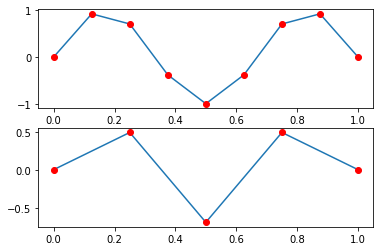

In [9]:
# Set up the fine grid first
x_fine = np.linspace(0,1,9)
y_fine = np.sin(3*np.pi*x_fine)

# Now the coarse grid
x_coarse = np.linspace(0,1,5)
y_coarse = np.zeros((5,1))

# Create the restriction matrix using full weighting
I_restrict = BuildFullWeighting(7)

# Interpolate from the coarse y values into the finer y-values
y_coarse[1:4,0] = mvmult(I_restrict,y_fine[1:8])

# Plot the coarse grid quantities as a blue line and the fine grid as red circles
fig, axs = plt.subplots(2,1)
axs[0].plot(x_fine, y_fine, '-', x_fine, y_fine,'ro')
axs[1].plot(x_coarse,y_coarse,'-',x_coarse, y_coarse, 'ro')

While, for simplicity in presentation, we will not be presenting a 2D problem, the stencil for the full weighting operator in this case is given:
$$
\frac{1}{16}
\begin{bmatrix}
1 & 2 & 1 \\
2 & 4 & 2 \\
1 & 2 & 1
\end{bmatrix}
$$

### Interpolation Operator
Now, let's discuss what's typically referred to as the **interpolation** or **prolongation** operator. It takes vectors in a coarse grid and interpolates them into a finer grid. We will denote it as $I_{2h}^h$ and it produces fine grid vectors according to the rule $I_{2h}^h x^{2h} = x^{h}$ where
\begin{align*}
x_{2j}^h &= x_j^{2h} \\
x_{2j+1}^h &= \frac{1}{2} \left( x_j^{2h} + x_{j+1}^{2h} \right)
\end{align*}
In other words, for the shared grid points, we simply let the values coinside and for the additional fine grid points, we use the average of the surrounding coarse grid points. We can describe this transformation with a matrix operator.  For example, if we have 8 subintervals in our fine grid (that is 7 interior nodes), and 4 subintervals in our coarse grid (with 3 interior nodes), then we have the following:
$$
I_{2h}^h x^{2h} = \frac{1}{2} 
\begin{bmatrix}
1 & & \\
2 & & \\
1 & 1 & \\
& 2 & \\
& 1 & 1 \\
& & 2 \\
& & 1
\end{bmatrix}
\begin{bmatrix}
x_1 \\ x_2 \\ x_3 \\
\end{bmatrix}_{2h}
= \begin{bmatrix}
x_1 \\ x_2 \\ x_3 \\ x_4 \\ x_5 \\ x_6 \\ x_7
\end{bmatrix}_h = x^h
$$
Another advantage of using the full weighting operator for the restriction operator is that $I_{2h}^h = c(I_h^{2h})^T$.  This is an important property for a lot of the theory of multigrid.
We can also depict this graphically.

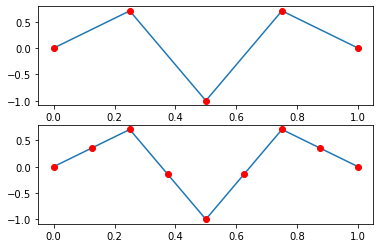

In [10]:
# Set up the coarse grid first
x_coarse = np.linspace(0,1,5)
y_coarse = np.sin(3*np.pi*x_coarse)

# Now the fine grid
x_fine = np.linspace(0,1,9)
y_fine = np.zeros((9,1))

# Create the prolongation matrix - it's the transpose of the restriction operator created earlier
I_prolong = 2*I_restrict.T

# Interpolate from the coarse y values into the finer y-values
y_fine[1:8,0] = mvmult(I_prolong, y_coarse[1:4])

# Plot the coarse grid quantities as a blue line and the fine grid as red circles
fig, axs = plt.subplots(2,1)
axs[0].plot(x_coarse,y_coarse,'-',x_coarse, y_coarse, 'ro')
axs[1].plot(x_fine, y_fine, '-', x_fine, y_fine,'ro')

### Galerkin Projection
The last piece we need to discuss is the creation of the coarse grid version of the $A^{2h}$ matrix.
One option is to generate a discretization for the coarse grid as well as the fine grid. This
technique can be cumbersome, and adds to the effort involved in utilizing the multigrid method.
Another option is to use the **Galerkin Projection**:
$$
A^{2h} = I_h^{2h} A^h I_{2h}^h
$$

As it turns out, if we use full weighting on the 1D problem, is projection will be the same as the
projection created by a discretization of the coarse grid. Let's demonstrate this, step-by-step.

First, let $e_j^{2h}$ denote the vector on the coarse grid with a 1 in the $j$th entry, and zeros
elsewhere. Then $A^{2h}e_j^{2h}$ will be the $j$th column of $A^{2h}$. We will calculate this column
in steps:
$$
I_{2h}^{h}e_j^{2h} =
\frac{1}{2}
\begin{bmatrix}
  1 &   &   & \\
  2 &   &   & \\
  1 & 1 &   & \\
    & 2 &   & \\
    & 1 & 1 & \\
    &   & 2 & \\
    &   & 1 & \ddots \\
    &   &   & \ddots \\
    &   &   & \ddots
\end{bmatrix}
\begin{bmatrix}
  0 \\ \vdots \\ 0 \\ 1 \\ 0 \\ \vdots \\ 0
\end{bmatrix}
=
\begin{bmatrix}
  0 \\ \vdots \\ 0 \\ \frac{1}{2} \\ 1 \\ \frac{1}{2} \\ 0 \\ \vdots \\ 0
\end{bmatrix}
$$
Notice, this vector now lies in the fine grid so we can now apply the fine grid operator $A^h$ to
this vector:
$$
A^h I_{2h}^h e_j^{2h} =
\frac{1}{h^2}
\begin{bmatrix}
  2 & -1  &    &    & \\
  -1 & 2  & -1 &    & \\
     & -1 & 2  & -1 &  \\
     &    & \ddots & \ddots & \ddots
\end{bmatrix}
\begin{bmatrix}
  0 \\ \vdots \\ 0 \\ \frac{1}{2} \\ 1 \\ \frac{1}{2} \\ 0 \\ \vdots \\ 0
\end{bmatrix}
=
\begin{bmatrix}
  0 \\ \vdots \\ 0 \\ \frac{-1}{2h^2} \\ \frac{1}{h^2} - \frac{1}{h^2} \\ \frac{-1}{2h^2} + \frac{2}{h^2}
  - \frac{1}{2h^2} \\ \frac{-1}{h^2} + \frac{1}{h^2} \\ \frac{-1}{2h^2} \\ 0 \\ \vdots \\ 0
\end{bmatrix}
= \begin{bmatrix}
  0 \\ \vdots \\ 0 \\ \frac{-1}{2h^2} \\ 0 \\ \frac{1}{h^2} \\ 0 \\ \frac{-1}{2h^2} \\ 0 \\ \vdots \\ 0
\end{bmatrix}
$$
Finally, we apply the restriction operator to this vector to obtain a vector in the course grid space:
$$
I_{h}^{2h} A^{h} I_{2h}^h e_j^{2h} =
\begin{bmatrix}
  \frac{1}{4} & \frac{1}{2} & \frac{1}{4} & & & & & & \\
  & & \frac{1}{4} & \frac{1}{2} & \frac{1}{4} & & & &  \\
  & & & & \frac{1}{4} & \frac{1}{2} & \frac{1}{4} & &  \\
  & & & &             &             & \ddots          & \ddots & \ddots \\
\end{bmatrix}
\begin{bmatrix}
  0 \\ \vdots \\ 0 \\ \frac{-1}{2h^2} \\ 0 \\ \frac{1}{h^2} \\ 0 \\ \frac{-1}{2h^2} \\ 0 \\ \vdots \\ 0
\end{bmatrix}
=
\begin{bmatrix}
  0 \\ \vdots \\ 0 \\ \frac{-1}{4h^2} \\ \frac{1}{2h^2} \\ \frac{-1}{4h^2} \\ 0 \\ \vdots \\ 0
\end{bmatrix}
=
\begin{bmatrix}
  0 \\ \vdots \\ 0 \\ \frac{-1}{(2h)^2} \\ \frac{2}{(2h)^2} \\ \frac{-1}{(2h)^2} \\ 0 \\ \vdots \\ 0
\end{bmatrix}
$$
Notice that this is exactly the same column we obtain from creating discretization on the coarse grid.  This projection will not be the same as the coarse grid discretization in a 2D problem or if full weighting is not used.  Nevertheless, it is a common practice and has been shown to produce good results.  It also has the advantage that it requires no extra effort on the part of the user, it can simply be another step in the algorithm.

## A Formal Two-Grid Cycle 
(in Briggs, this is called a Coarse Grid Correction Scheme)

1. Relax $\nu_1$ times on $A^h x^h = b^h$ on $\Omega^h$ with initial guess $x^h$
2. Compute $r^{2h} = I_h^{2h}(b^h - A^h x^h)$.
3. Solve $A^{2h} e^{2h} = r^{2h}$ on $\Omega^{2h}$
4. Correct fine grid approximation: $x^h \leftarrow x^h + I_{2h}^h e^{2h}$
5. Relax $\nu_2$ times on $A^h x^h = b^h$ on $\Omega^h$ with initial guess $x^h$

In [11]:
# Import CG code
import os
import sys
module_path = os.path.abspath(os.path.join('../CGProgrammingProblem'))
if module_path not in sys.path:
    sys.path.append(module_path)
from PCG import PCG

def TwoGridScheme(A_fine, b, numPreRelax, numPostRelax, numiters=1):
    # For simplicity, we assume A_fine is (2^n-1) by (2^n-1) for some n
    
    # We will also assume that A is SPD so that we can use CG to solve the coarse system
    
    # Build the restriction and prolongation operators
    # They can be re-used if we run more than 1 iteration
    I_Restrict = BuildFullWeighting(A_fine.shape[0])
    I_Prolong = 2*I_Restrict.T
    
    # Use an initial guess of zero
    x = np.zeros_like(b)
    
    # The coarse A only needs to be calculated once, using Galerkin Projection
    A_coarse = I_Restrict.dot(A_fine.dot(I_Prolong))
    
    # We could run this scheme more than once if more accuracy is required
    for i in range(numiters):
        # First we relax on the fine grid:
        x = Jacobi(x, A_fine, b, numiters=numPreRelax)
    
        # Now compute the restricted residual
        r_coarse = mvmult(I_Restrict, b - mvmult(A_fine, x))
    
        # Now we solve the coarse problem Ae = r, which is 
        # cheaper than solving the fine grid problem due to the decrease in size
        # We use the initial guess of zero
        (conv, _, e_coarse, _, _) = PCG(A_coarse, r_coarse, maxiter=100000)
        if not conv:
            raise RuntimeError("PCG did not converge on the coarse_grid")
    
        # Correct the fine-grid x with the prolongated residual
        x += mvmult(I_Prolong, e_coarse)
    
        # The above Prolongation could be introducing additional high frequency errors
        # So we relax again to get rid of them
        x = Jacobi(x, A_fine, b, numiters=numPostRelax)
    
    return x

Let's test it out.  We will generate `A_fine` to be $(2^{16}-1)\times(2^{16}-1)$. We use the method of manufactured solutions to generate $b$ from a random true solution $x^*$ and start with $x_0 = 0$ for an initial guess.  We will run 5 iterations of Jacobi before and after the transfer to the coarse grid.

In [12]:
N = 2**16

A_fine = GeneratePoisson(N)
xTrue = rs.rand(N-1)
b = mvmult(A_fine, xTrue)
x = np.zeros_like(b)

results = PrettyTable()
results.field_names = ["Algorithm", "Num. Iterations", "Rel. Error", "Time (sec)"]
results.align = "l"

# Run Jacobi - 1000 iterations
startT = time.time()
x_Jac = Jacobi(np.zeros_like(b), A_fine, b, 100)
endT = time.time()
relError_Jac = norm(x_Jac - xTrue)/norm(xTrue)
results.add_row(["Jacobi", 100, relError_Jac, endT-startT ])

# Run TwoGrid - 1 pre and 1 post relax, 1 iteration
startT = time.time()
x_TG = TwoGridScheme(A_fine, b, 1, 1, 1)
endT = time.time()
relError = norm(x_TG - xTrue)/norm(xTrue)
results.add_row(["Two Grid (1 pre, 1 post)", 1, relError, endT-startT])

# Run TwoGrid - 1 pre and 1 post relax, 3 iteration
startT = time.time()
x_TG = TwoGridScheme(A_fine, b, 1, 1, 3)
endT = time.time()
relError = norm(x_TG - xTrue)/norm(xTrue)
results.add_row(["Two Grid (1 pre, 1 post)", 3, relError, endT-startT])

# Run TwoGrid - 3 pre and 3 post relax, 1 iteration
startT = time.time()
x_TG = TwoGridScheme(A_fine, b, 3, 3, 1)
endT = time.time()
relError = norm(x_TG - xTrue)/norm(xTrue)
results.add_row(["Two Grid (3 pre, 3 post)", 1, relError, endT-startT])

print(results)
display(HTML(results.get_html_string()))

Algorithm,Num. Iterations,Rel. Error,Time (sec)
Jacobi,100,0.8738113206251781,37.4556839466095
"Two Grid (1 pre, 1 post)",1,0.2948427282253173,8.900107860565186
"Two Grid (1 pre, 1 post)",3,0.23544666306232065,32.96256685256958
"Two Grid (3 pre, 3 post)",1,0.2354461597919998,11.599387884140015


While these numbers look impressive, you can't read too much into it since we are actually cheating a little bit by using Conjugate Gradient on the coarse level. There is some hope, however, looking at the last two rows. The run that completes more relaxation and few CG solves acheives the same error in half the time. Let's see how long it takes CG to solve the fine grid problem to the same relative residual and try using more relaxations for the Two Grid method.

In [13]:
# Run TwoGrid - 5 pre and 5 post relax, 1 iteration
startT = time.time()
x_TG = TwoGridScheme(A_fine, b, 5, 5, 1)
endT = time.time()
relError = norm(x_TG - xTrue)/norm(xTrue)
results.add_row(["Two Grid (5 pre, 5 post)", 1, relError, endT-startT])

# Run CG to the similar relative error
startT = time.time()
(conv, iters_CG, x_CG, _, _) = PCG(A_fine, b, maxiter=100000, tau=1.8e-9)
endT = time.time()
relError = norm(x_CG - xTrue)
results.add_row(["CG", iters_CG, relError, endT-startT])


display(HTML(results.get_html_string()))

Algorithm,Num. Iterations,Rel. Error,Time (sec)
Jacobi,100,0.8738113206251781,37.4556839466095
"Two Grid (1 pre, 1 post)",1,0.2948427282253173,8.900107860565186
"Two Grid (1 pre, 1 post)",3,0.23544666306232065,32.96256685256958
"Two Grid (3 pre, 3 post)",1,0.2354461597919998,11.599387884140015
"Two Grid (5 pre, 5 post)",1,0.20961930771533185,14.517709016799927
CG,46078,0.21183365080071145,28.23505210876465


Looking at these results, we see that we get the same error, but about a 2x speedup if we use CG on the coarse grid then just use Jacobi on the fine grid to refine that solution.  Still, there's more we can do to make this better.  If you look at step 3 in the algorithm above, you'll notice we do a linear system solve on the coarse grid, but this solve is also of the form $Ax = b$. That means we could apply this process __recursively__ which is where the real power of Multigrid appears.

## Typical Multigrid Cycles
There are several ways to create a recursive multigrid pattern.  The most common by far is known as the V-Cycle.
### V-Cycle
In the V-Cycle, we run the above Two-Grid Cycle, but replace the solve on the coarse grid with a recursive call another Two-Grid Cycle, where we move to yet another coarser mesh. This is called a V-Cycle because if you trace the work done on the various grid levels, you get a picture in the shape of a V:

<img src="Graphics/V-Cycle-Graphic.png" alt="V-Cycle" style="width: 300px;"/>

We can get this cycle by modifying the `TwoGridScheme` function above:

In [14]:
def VCycle(A_fine, b, numPreRelax, numPostRelax, coarsest_N, numiters=1, x=None):
    # For simplicity, we assume A_fine is (2^n-1) by (2^n-1) 
    #                       and A_coarse is (2^(n-1)-1) by (2^(n-1)-1) for some n
    #
    # We will also assume that A is SPD so that we can use CG to solve the coarse system
    #
    # It should be noted that this implementation is not best to use if numiters is not 1
    # since we are not caching the calculated A, I_restrict, I_prolong matrices
    # here we re-calculate them during each V, doing much extra computation
    
    # Build the restriction and prolongation operators
    # They can be re-used if we run more than 1 iteration
    N = A_fine.shape[0]
    I_Restrict = BuildFullWeighting(N)
    I_Prolong = 2*I_Restrict.T
    
    # start with the initial guess of zero if one isn't given
    if x is None:
        x = np.zeros_like(b)
    
    # Calculate the coarse mesh
    A_coarse = I_Restrict.dot(A_fine.dot(I_Prolong))
    N_coarse = A_coarse.shape[0]
    
    # We could run more than once if more accuracy is required
    for i in range(numiters):
        # First we relax on the fine grid:
        x = Jacobi(x, A_fine, b, numiters=numPreRelax)
    
        # Now compute the restricted residual
        r_coarse = mvmult(I_Restrict, b - mvmult(A_fine, x))
    
        # If not on the "bottom of the V", we call recursively
        if N_coarse > coarsest_N:
            # We start with an initial guess of zero, only 1 iteration to get the V-Cycle
            e_coarse = VCycle(A_coarse, r_coarse, numPreRelax, numPostRelax, coarsest_N, 1)
        else: # If on the bottom of the V, we solve the coarsest matrix exactly
            (conv, _, e_coarse, _, _) = PCG(A_coarse, r_coarse, maxiter=100000)
            if not conv:
                raise RuntimeError("PCG did not converge on the coarse_grid")
                
    
        # Correct the fine-grid x with the prolongated residual
        x += mvmult(I_Prolong, e_coarse)
    
        # The above Prolongation could be introducing additional high frequency errors
        # So we relax again to get rid of them
        x = Jacobi(x, A_fine, b, numiters=numPostRelax)
    
    return x

In [15]:
# Run VCycle
startT = time.time()
x_VCyc = VCycle(A_fine, b, 3, 3, 128, numiters=1)
endT = time.time()
relError = norm(x_VCyc - xTrue)/norm(xTrue)
results.add_row(["V-Cycle (3 pre, 3 post, 127x127 coarse)", 1, relError, endT-startT])

# Run VCycle
startT = time.time()
x_VCyc = VCycle(A_fine, b, 3, 3, 128, numiters=3)
endT = time.time()
relError = norm(x_VCyc - xTrue)/norm(xTrue)
results.add_row(["V-Cycle (3 pre, 3 post, 127x127 coarse)", 3, relError, endT-startT])

# Run VCycle
startT = time.time()
x_VCyc = VCycle(A_fine, b, 5, 5, 128, numiters=1)
endT = time.time()
relError = norm(x_VCyc - xTrue)/norm(xTrue)
results.add_row(["V-Cycle (5 pre, 5 post, 127x127 coarse)", 1, relError, endT-startT])

display(HTML(results.get_html_string()))

Algorithm,Num. Iterations,Rel. Error,Time (sec)
Jacobi,100,0.8738113206251781,37.4556839466095
"Two Grid (1 pre, 1 post)",1,0.2948427282253173,8.900107860565186
"Two Grid (1 pre, 1 post)",3,0.23544666306232065,32.96256685256958
"Two Grid (3 pre, 3 post)",1,0.2354461597919998,11.599387884140015
"Two Grid (5 pre, 5 post)",1,0.20961930771533185,14.517709016799927
CG,46078,0.21183365080071145,28.23505210876465
"V-Cycle (3 pre, 3 post, 127x127 coarse)",1,0.23201901786183127,4.749081134796143
"V-Cycle (3 pre, 3 post, 127x127 coarse)",3,0.18222284649234705,13.906550884246826
"V-Cycle (5 pre, 5 post, 127x127 coarse)",1,0.2076762825119375,7.67667818069458


This looks like a good improvement, they are the fastest single run so far and achieve about the same error as the other runs. During these runs, I observed that the CPU usage in my multi-core CPU is higher for the some of the computation and gets lower for the coarser meshes.  This makes sense, those matrices are smaller and hence, take less computation.  This however means that the size of the coarsest grid should make a difference. If the course grid is too small, the CPU is under-utilized, and if the coarse grid is too large, CG will take longer than moving to a coarser grid. Let's see if we can find a more optimal coarse-grid size.

We run trials of 1 V-Cycle with 5 pre and 5 post relaxations for differing coarse matrix sizes:

In [16]:
coarseGridSize_results = PrettyTable()
coarseGridSize_results.field_names = ["Coarse Matrix Size", "Rel Error", "Time (sec)"]
coarseGridSize_results.align = "l"

relErrors = np.ones(14)
timings = np.zeros(14)

for exp in range(2,16):
    startT = time.time()
    x_VCyc = VCycle(A_fine, b, 5, 5, 2**exp, numiters=1)
    endT = time.time()
    relErrors[exp-2] = norm(x_VCyc - xTrue)/norm(xTrue)
    timings[exp-2] = endT-startT
    coarseGridSize_results.add_row([f'{2**exp - 1}x{2**exp-1}', relErrors[exp-2], timings[exp-2]])
    
display(HTML(coarseGridSize_results.get_html_string()))

Coarse matrix Size,Rel Error,Time (sec)
3x3,0.2086308040422921,7.645226001739502
7x7,0.20801730210638644,7.707892656326294
15x15,0.20784353346814935,7.62153697013855
31x31,0.20774165075263482,7.640967845916748
63x63,0.2076860851294018,7.680612564086914
127x127,0.2076762825119375,7.65519905090332
255x255,0.20766746557655444,7.827473402023315
511x511,0.20767023081402777,7.940810203552246
1023x1023,0.20770524920319444,8.075040340423584
2047x2047,0.20777185376532828,7.64995002746582


It appears that a $8191\times 8191$ matrix is the most efficient coarse grid size for this computer. Any larger and the CG method takes too long, either due to cache size, number of cache misses, or simply the number of iterations CG needs to converge for the coarse problem (due to the increased condition number). Let's add this run to our table to see all the results together:

In [17]:
results.add_row(["V-Cycle (5 pre, 5 post, 8191x8191 coarse)", 1, relErrors[11], timings[11]])

display(HTML(results.get_html_string()))

Algorithm,Num. Iterations,Rel. Error,Time (sec)
Jacobi,100,0.8738113206251781,37.4556839466095
"Two Grid (1 pre, 1 post)",1,0.2948427282253173,8.900107860565186
"Two Grid (1 pre, 1 post)",3,0.23544666306232065,32.96256685256958
"Two Grid (3 pre, 3 post)",1,0.2354461597919998,11.599387884140015
"Two Grid (5 pre, 5 post)",1,0.20961930771533185,14.517709016799927
CG,46078,0.21183365080071145,28.23505210876465
"V-Cycle (3 pre, 3 post, 127x127 coarse)",1,0.23201901786183127,4.749081134796143
"V-Cycle (3 pre, 3 post, 127x127 coarse)",3,0.18222284649234705,13.906550884246826
"V-Cycle (5 pre, 5 post, 127x127 coarse)",1,0.2076762825119375,7.67667818069458
"V-Cycle (5 pre, 5 post, 8191x8191 coarse)",1,0.20816046064354068,7.1476757526397705


Finally, let's run some extra iterations to see what the convergence looks like.  Since the code below interupts the V-Cycle function after every V-Cycle, we are doing extra work and so the timings are not representative, hence we won't calculate them.

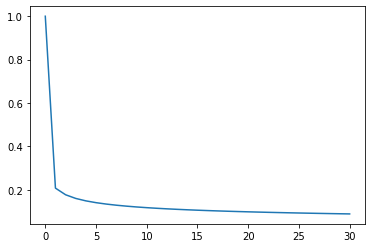

In [18]:
maxIters = 30
coarseGridSize = 2**13
numRelax = 5

# container to hold the errors
relError = np.ones(maxIters+1)

# Provide an initial guess
x_VCyc = np.zeros_like(b)

for i in range(1,maxIters+1):
    x_VCyc = VCycle(A_fine, b, numRelax, numRelax, coarseGridSize, numiters=1, x=x_VCyc)
    relError[i] = norm(x_VCyc - xTrue)/norm(xTrue)

plt.plot(relError)

Notice the large decrease in error from the first iteration (80% reduction).  This is one of the primary reasons why one iteration of multigrid is widely used as a preconditioner.

## Other Multigrid Cycles
While the V-Cycle is the most popular, there are other proposed cycles as well.  One possible extension is to recursively run two consecutive V-Cycles:

<img src="Graphics/W-Cycle-Graphic.png" alt="W-Cycle" style="width: 400px;"/>

This is typically called a **W-Cycle**. You can of course extend this to running more than 2 consecutive V-Cycles, Briggs's book calls these **$\mu$-Cycles** (where $\mu$ refers to the number of consecutive V-Cycles completed recursively).

Finally, there is the **Full Multigrid Cycle**:

<img src="Graphics/FMV-Cycle-Graphic.png" alt="FMV-Cycle" style="width: 400px;"/>

The idea behind the full multigrid cycle is to first solve on the coarse grid, getting a good starting guess for the next finer grid.  Then run a V-Cycle on that grid to get a good starting point for the next finer grid, and continue that process until the finest grid is reached.

## Tuning Multigrid
There are several "knobs to turn" to tune Multigrid Methods:
- Several different relaxation schemes have been shown to be effective: weighted Jacobi, Red-Black Jacobi, Gauss-Seidel, Red-Black Gauss Seidel, SOR, Block Jacobi, Block Gauss-Seidel
- Method for solving the coarsest grid problem can be chosen
- The number of relaxations can have some effect in the convergence of the method, typically 3-5 are used
- Which type of cycle to use: the most common is the V-Cycle, but the W and Full Multigrid Cycle are also common, $\mu$-cycles with $\mu \geq 3$ are rarely seen

# Cons of Multigrid
While the multigrid method has been shown to be effective in terms of computational time, it does cost more in terms of memory. This is due to the fact that all grids need to be in storage as once.  The cost here is migated however since the dimensions of the coarse matrices decreases exponentially.

Another negative aspect of multrigrid is the fact that it is not as effective on smaller matrices.  For example, straight CG is often faster than multigrid for smaller matrix sizes, where CG does not have to complete as many iterations.

# Algebraic Multigrid
While geometric multigrid is useful for gaining intuition into multigrid methods, it's not often used in practice. It's tougher to design the restriction and prolongation operators for non-uniform meshes where the number of bordering nodes is variable.  It's also less useful for systems with more than one state variable, since only the physical dimensions can be made coarser.  Instead, we will use the same idea to develop a multigrid method that doesn't explicity depend on the mesh, but instead depends on the coefficient matrix.

If we look at our matrix
$$
A = \frac{1}{h^2}
\begin{bmatrix}
2  & -1 &        &        &        &   \\
-1 &  2 & -1     &        &        &   \\
   & -1 &  2     &     -1 &        &   \\
   &    & \ddots & \ddots & \ddots &   \\
   &    &        &     -1 &      2 & -1 \\
   &    &        &        &     -1 &  2
\end{bmatrix}
$$
we can interpret it in the following way: an entry's magnitude in the matrix corresponds to its level of contribution in calculating the element on the diagonal.  For example, row 2 has $-1/h^2$, $2/h^2$, and $-1/h^2$ in the first three columns. This signifies that only $x_1, x_2, x_3$ directly contribute to the node $x_2$, with the value $x_2$ contributing more than $x_1$ and $x_3$. In algebriac multigrid, we use this idea of "significance" to determine which unknowns can be "merged" to obtain a coarse matrix. This process will also create prolongation and restriction operators which only depend on the coefficient matrix and not on the geometric structure of the physical problem. Algebraic multigrid can therefore be programmed in a more general way and can more easily extended to more problems. This property also contributes to its usefulness as a preconditioner since it takes less setup and quickly gives modest accuracy. 